<a href="https://colab.research.google.com/github/parthasarathi1234/DL_assignment_1/blob/main/DL_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.metrics import confusion_matrix
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data();
x_train_images, x_validation_images,y_train_labels, y_validation_labels  = train_test_split(x_train,y_train,test_size = 0.1)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(x_train_images.shape,x_validation_images.shape,y_train_labels.shape,y_validation_labels.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(54000, 28, 28) (6000, 28, 28) (54000,) (6000,)


In [2]:
# !pip install wandb
!pip install -U wandb

import wandb
from wandb.keras import WandbCallback
import socket
socket.setdefaulttimeout(30)
wandb.login()
wandb.init(project="cs23m035_DL_Assignment1")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs23m035. Use `wandb login --relogin` to force relogin


#Question1

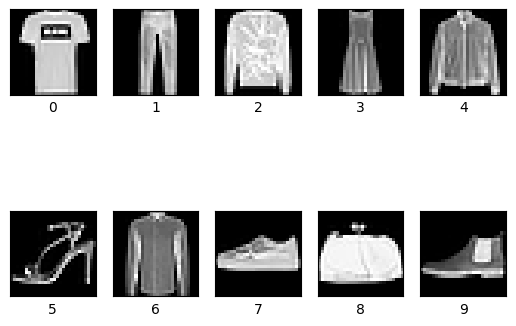

In [3]:
n=0
i=0
while(n!=10):
  if(y_train[i]==n):
    plt.subplot(2,5,n+1)
    plt.gray()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(y_train[i])
    n=n+1
  i=i+1

plt.savefig('images.png')
wandb.log({'image':wandb.Image('images.png')})
wandb.log({'plt':plt})
plt.show()


#Question 2


### weights generation   ,   Activation functions

In [49]:
def weight(No_of_layers,neurons,weightInit):
  weights=[]
  bias=[]

  if(weightInit=='random'):
  # input layer
    weights.append(0.01*np.random.randn(neurons,784))
    bias.append(0.01*np.random.randn(neurons,1))

    # Hidden layer
    for i in range(1,No_of_layers):
      weights.append(0.01*np.random.randn(neurons,neurons))
      bias.append(0.01*np.random.randn(neurons,1))

    # output layer
    weights.append(0.01*np.random.randn(10,neurons))
    bias.append(0.01*np.random.randn(10,1))

  elif(weightInit=='xavier'):
    # input layer
    weights.append(0.01*np.random.randn(neurons,784))
    bias.append(np.zeros((neurons,1)))

    # Hidden layer
    for i in range(1,No_of_layers):
      weights.append(0.01*np.random.randn(neurons,neurons))
      bias.append(np.zeros((neurons,1)))

    # output layer
    weights.append(0.01*np.random.randn(10,neurons))
    bias.append(np.zeros((10,1)))

  else:
    weights.append(np.random.randn(neurons,784))
    bias.append(np.random.randn(neurons,1))

    # Hidden layer
    for i in range(1,No_of_layers):
      weights.append(np.random.randn(neurons,neurons))
      bias.append(np.random.randn(neurons,1))

    # output layer
    weights.append(0.01*np.random.randn(10,neurons))
    bias.append(0.01*np.random.randn(10,1))


  return weights,bias



def sigmoid(a):
  z=np.clip(a,-500, 500)
  return 1 / (1 + np.exp(-z))

def tanh(a):
  z=np.clip(a,-50,50)
  return np.tanh(z)

def softmax(a):
  x=1e-6
  return (np.exp(a-max(a))/(sum(np.exp(a-max(a)))+x))

def tanh_derivative(z):
  return 1-np.tanh(z)**2

def relu(Z):
    A = np.maximum(0, Z)
    return A

def relu_derivative(z):
  return np.where(z>0,1,0)

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))



def  feeb_forward(x,layers,act,wei,b):
  pre_activation=[0 for i in range(layers+1)]
  activation=[0 for i in range(layers+1)]
  z=x.reshape(784,1)/255.0
  for i in range(layers+1):
    if(i==0):
      pre_activation[i]=np.matmul(wei[i],z)+b[i]
    elif(i==layers):
        pre_activation[i]=b[i]+np.matmul(wei[i],z)
        activation[i]=np.copy(softmax(pre_activation[i]))
        continue
    else:
      pre_activation[i]=b[i]+np.matmul(wei[i],z)  # pre activation
    if(act=="sigmoid"):
      z=sigmoid(pre_activation[i])
    elif(act=="tanh"):
      z=tanh(pre_activation[i])
    elif(act=="ReLU"):
      z=relu(pre_activation[i])
    else:
      z=identity(pre_activation[i])
    activation[i]=z
  return pre_activation,activation,z

def back_propagation(x_t,y_train,z,H,A,layers,W,activation,loss_Fun):
  update_x=x_t.reshape(784,1)/255.0
  dw=[0 for i in range(layers+1)]
  db=[0 for i in range(layers+1)]
  y=np.zeros((10,1))
  y[y_train]=1
  if(loss_Fun=='cross_entropy'):
    loss=-(y-H[layers])
  else:
    loss=(H[layers]-y)*H[layers]*(1-H[layers])
  for k in range(len(W)-1,-1,-1):
    if(k==0):
        dw[0]=np.matmul(loss,update_x.T)
        db[0]=np.copy(loss)
        continue
    dw[k]=np.matmul(loss,(H[k-1].T))
    db[k]=np.copy(loss)
    loss_dh=np.matmul((W[k].T),loss)
    if(activation=="tanh"):
      x=tanh_derivative(A[k-1])
    elif(activation=="sigmoid"):
      x=sigmoid_derivative(A[k-1])
    elif(activation=="ReLU"):
      x=relu_derivative(A[k-1])
    else:
      x=identity_derivative(A[k-1])
    loss=np.multiply(loss_dh,x)
  return dw,db

def accuracy(theta_w,theta_b,X,Y,activationfun,layers,loss_Fun):
  # print("accuracy")
  count=0
  loss=0
  # print(X.shape)
  for train_ima,train_labe in zip(X,Y):
    p_act, act, z = feeb_forward(train_ima, layers, activationfun, theta_w, theta_b)
    # print(np.argmax(z),np.argmax(act[layers]),end=",")
    if(np.argmax(act[layers])==train_labe):
      count=count+1

    if(loss_Fun=='crossEntropy'):
      loss+=-np.log(act[layers])[train_labe][0]
    else:
      loss+=(np.argmax(act[layers]-Y.shape[0])**2)
    loss=loss/Y.shape[0]
    acc=(count/Y.shape[0])
  return acc*100,loss*100

def accuracy_confusion(theta_w,theta_b,X,Y,activationfun,layers,loss_Fun,predicted,original):
  # print("accuracy")
  count=0
  loss=0
  # print(X.shape)
  for train_ima,train_labe in zip(X,Y):
    p_act, act, z = feeb_forward(train_ima, layers, activationfun, theta_w, theta_b)
    # print(np.argmax(z),np.argmax(act[layers]),end=",")
    original.append(train_labe)
    predicted.append(np.argmax(act[layers]))
    if(np.argmax(act[layers])==train_labe):
      count=count+1

    if(loss_Fun=='crossEntropy'):
      loss+=-np.log(act[layers])[train_labe][0]
    else:
      loss+=(np.argmax(act[layers]-Y.shape[0])**2)
    loss=loss/Y.shape[0]
    acc=(count/Y.shape[0])
  return acc*100,loss*100





def stochastic_gradient_descent(epochs,eta,layers,neurons,activation_fun,weightInit,weightDecay,loss_Fun):
  W, B = weight(layers,neurons,weightInit)
  for i in range(epochs):
    dw=[[0 for colu in range(row)] for row in range(len(W))]
    db=[[0 for colu in range(row)] for row in range(len(B))]

    for train_ima,train_labe in zip(x_train_images,y_train_labels):
      A,H,Z=feeb_forward(train_ima,layers,activation_fun,W,B)
      current_dw,current_db=back_propagation(train_ima,train_labe,Z,H,A,layers,W,activation_fun,loss_Fun)

      for k in range(layers+1):
        W[k]=W[k]-eta*current_dw[k]-(weightDecay*W[k])
        B[k]=B[k]-eta*current_db[k]

    acc,loss=accuracy(W,B,x_train_images,y_train_labels,activation_fun,layers,loss_Fun)
    v_acc,v_loss=accuracy(W,B,x_validation_images,y_validation_labels,activation_fun,layers,loss_Fun)
    print("Accuracy")
    print(acc,loss,v_acc,v_loss)
    wandb.log({"Train_Accuracy" : acc,"Train_Loss" : loss,"Validation_acc" : v_acc,"validation_loss" : v_loss,'epoch':i})


def momentum_gradient_descent(epochs,eta,layers,neurons,activation_fun,batchSize,weightInit,weightDecay,loss_Fun):
  beta=0.9
  W,B=weight(layers,neurons,weightInit)
  pre_v_w=[0 for i in range(layers+1)]
  pre_v_b=[0 for i in range(layers+1)]

  for i in range(epochs):
    batch=1
    dw=[0 for i in range(layers+1)]
    db=[0 for i in range(layers+1)]
    for train_ima,train_labe in zip(x_train_images,y_train_labels):
      A,H,Z=feeb_forward(train_ima,layers,activation_fun,W,B)
      current_dw, current_db = back_propagation(train_ima,train_labe,Z,H,A,layers,W,activation_fun,loss_Fun)

      for k in range(len(W)):
        dw[k]+=current_dw[k]
        db[k]+=current_db[k]

      if(batch%batchSize==0):
        for k in range(len(W)):
          v_w=beta*pre_v_w[k]+dw[k]
          v_b=beta*pre_v_b[k]+db[k]

          W[k]=W[k]-(eta*v_w) - (weightDecay * W[k])
          B[k]=B[k]-eta*v_b

          pre_v_w[k]=v_w
          pre_v_b[k]=v_b

        for xw in dw:
          xw[:]=0
        for xb in db:
          xb[:]=0
      batch+=1

    acc,loss=accuracy(W,B,x_train_images,y_train_labels,activation_fun,layers,loss_Fun)
    v_acc,v_loss=accuracy(W,B,x_validation_images,y_validation_labels,activation_fun,layers,loss_Fun)
    print("Accuracy")
    print(acc,loss,v_acc,v_loss)
    wandb.log({"Train_Accuracy" : acc,"Train_Loss" : loss,"Validation_acc" : v_acc,"validation_loss" : v_loss,'epoch':i})


def nesterov_accelerated_gradient_descent(epochs,layers,neurons,eta,activation_fun,batchSize,weightInit,weightDecay,loss_Fun):
  beta=0.9
  W,B=weight(layers,neurons,weightInit)
  pre_v_w=[0 for i in range(layers+1)]
  pre_v_b=[0 for i in range(layers+1)]

  v_w=[0 for i in range(layers+1)]
  v_b=[0 for i in range(layers+1)]

  for i in range(epochs):
    batch=1
    dw=[0 for i in range(layers+1)]
    db=[0 for i in range(layers+1)]

    for k in range(len(W)):
      W[k] = W[k] - beta * pre_v_w[k]
      B[k] = B[k] - beta * pre_v_b[k]
    for train_ima,train_labe in zip(x_train_images,y_train_labels):
      A,H,Z=feeb_forward(train_ima,layers,activation_fun,W,B)
      current_dw,current_db=back_propagation(train_ima,train_labe,Z,H,A,layers,W,activation_fun,loss_Fun)

      for k in range(len(W)):
          dw[k]+=current_dw[k]
          db[k]+=current_db[k]

      if(batch%batchSize==0):
        for k in range(len(W)):
          W[k]=W[k]-eta*dw[k]-(weightDecay*W[k])
          B[k]=B[k]-eta*db[k]
          pre_v_w[k]=eta*dw[k]+beta*pre_v_w[k]
          pre_v_b[k]=eta*db[k]+beta*pre_v_b[k]
        for xw in dw:
          xw[:]=0
        for xb in db:
          xb[:]=0
      batch+=1
    acc, loss = accuracy(W,B,x_train_images,y_train_labels,activation_fun,layers,loss_Fun)
    v_acc, v_loss = accuracy(W,B,x_validation_images,y_validation_labels,activation_fun,layers,loss_Fun)
    print("Accuracy")
    print(acc,loss,v_acc,v_loss)
    wandb.log({"Train_Accuracy" : acc,"Train_Loss" : loss,"Validation_acc" : v_acc,"validation_loss" : v_loss,'epoch':i})



def rms_prop(epochs,layers,neurons,eta,activation_fun,batchSize,weightInit,weightDecay,loss_Fun):
  beta=0.5
  W,B=weight(layers,neurons,weightInit)
  eps=1e-4
  v_w=[0 for i in range(layers+1)]
  v_b=[0 for i in range(layers+1)]

  for i in range(epochs):
    batch=1
    dw=[0 for i in range(layers+1)]
    db=[0 for i in range(layers+1)]
    for train_ima,train_labe in zip(x_train_images,y_train_labels):
      A, H, Z = feeb_forward(train_ima,layers,activation_fun,W,B)
      current_dw, current_db = back_propagation(train_ima,train_labe,Z,H,A,layers,W,activation_fun,loss_Fun)

      for k in range(len(W)):
        dw[k]=dw[k]+current_dw[k]
        db[k]=db[k]+current_db[k]
      if(batch%batchSize==0):
        for k in range(len(W)):
          v_w[k]=beta*v_w[k]+(1-beta)*pow(dw[k],2)
          v_b[k]=beta*v_b[k]+(1-beta)*pow(db[k],2)
          W[k]=W[k]-eta*dw[k]/(np.sqrt(v_w[k])+eps) -(weightDecay*W[k])
          B[k]=B[k]-eta*db[k]/(np.sqrt(v_b[k])+eps)

        for xw in dw:
          xw[:]=0
        for xb in db:
          xb[:]=0
      batch+=1

    acc,loss=accuracy(W,B,x_train_images,y_train_labels,activation_fun,layers,loss_Fun)
    v_acc,v_loss=accuracy(W,B,x_validation_images,y_validation_labels,activation_fun,layers,loss_Fun)
    print("Accuracy")
    print(acc,loss,v_acc,v_loss)
    wandb.log({"Train_Accuracy" : acc,"Train_Loss" : loss,"Validation_acc" : v_acc,"validation_loss" : v_loss,'epoch':i})
  return W,B



def adam(epochs,eta,activation_fun,layers,neurons,batchSize,weightInit,weightDecay,loss_Fun):
  beta1=0.9
  beta2=0.999
  W,B=weight(layers,neurons,weightInit)
  v_w=[np.zeros_like(w) for w in W]
  v_b=[np.zeros_like(w) for w in B]
  m_w=[np.zeros_like(w) for w in W]
  m_b=[np.zeros_like(w) for w in B]
  eps=1e-10
  for i in range(epochs):
    batch=1
    dw=[np.zeros_like(w) for w in W]
    db=[np.zeros_like(w) for w in B]

    for train_ima,train_labe in zip(x_train_images,y_train_labels):
      A,H,Z=feeb_forward(train_ima,layers,activation_fun,W,B)
      current_dw,current_db=back_propagation(train_ima,train_labe,Z,H,A,layers,W,activation_fun,loss_Fun)

      for k in range(len(W)):
        dw[k]=dw[k]+current_dw[k]
        db[k]=db[k]+current_db[k]

      if(batch%batchSize==0):
        for k in range(len(W)):
          m_w[k]=beta1*m_w[k]+(1-beta1)*dw[k]
          m_b[k]=beta1*m_b[k]+(1-beta1)*db[k]
          v_w[k]=beta2*v_w[k]+(1-beta2)*pow(dw[k],2)
          v_b[k]=beta2*v_b[k]+(1-beta2)*pow(db[k],2)

          m_w_hat=m_w[k]/(1-pow(beta1,k+1))
          m_b_hat=m_b[k]/(1-pow(beta1,k+1))
          v_w_hat=v_w[k]/(1-pow(beta2,k+1))
          v_b_hat=v_b[k]/(1-pow(beta2,k+1))

          W[k]=W[k]-eta*m_w_hat/(np.sqrt(v_w_hat)+eps) - (weightDecay*W[k])
          B[k]=B[k]-eta*m_b_hat/(np.sqrt(v_b_hat)+eps)
        for xw in dw:
          xw[:]=0
        for xb in db:
          xb[:]=0
      batch+=1
    acc, loss = accuracy(W,B,x_train_images,y_train_labels,activation_fun,layers,loss_Fun)
    v_acc, v_loss = accuracy(W,B,x_validation_images,y_validation_labels,activation_fun,layers,loss_Fun)
    x_acc,y_loss=accuracy(W,B,x_test,y_test,activation_fun,layers,loss_Fun)
    print("Accuracy")
    print(acc,loss,v_acc,v_loss,x_acc,y_loss)

    wandb.log({"Train_Accuracy" : acc,"Train_Loss" : loss,"Validation_acc" : v_acc,"validation_loss" : v_loss,'epoch':i})
  return W,B



def nadam(eta,layers,neurons,epochs,activation_fun,batchSize,weightInit,weightDecay,loss_Fun):
  beta1=0.9
  beta2=0.999
  W,B=weight(layers,neurons,weightInit)
  v_w=[np.zeros_like(w) for w in W]
  v_b=[np.zeros_like(w) for w in B]
  m_w=[np.zeros_like(w) for w in W]
  m_b=[np.zeros_like(w) for w in B]
  eps=1e-10
  for i in range(epochs):
    temp=1
    dw=[np.zeros_like(w) for w in W]
    db=[np.zeros_like(w) for w in B]
    for train_ima,train_labe in zip(x_train_images,y_train_labels):
      A,H,Z=feeb_forward(train_ima,layers,activation_fun,W,B)
      current_dw,current_db=back_propagation(train_ima,train_labe,Z,H,A,layers,W,activation_fun,loss_Fun)
      # current_dw.reverse()
      # current_db.reverse()

      for k in range(len(W)):
        dw[k]+=current_dw[k]
        db[k]+=current_db[k]

      if(temp%batchSize==0):
        for k in range(len(W)):
          m_w[k]=beta1*m_w[k]+(1-beta1)*dw[k]
          m_b[k]=beta1*m_b[k]+(1-beta1)*db[k]
          v_w[k]=beta2*v_w[k]+(1-beta2)*pow(dw[k],2)
          v_b[k]=beta2*v_b[k]+(1-beta2)*pow(db[k],2)

          m_w_hat=m_w[k]/(1-pow(beta1,i+1))
          m_b_hat=m_b[k]/(1-pow(beta1,i+1))
          v_w_hat=v_w[k]/(1-pow(beta2,i+1))
          v_b_hat=v_b[k]/(1-pow(beta2,i+1))

          W[k]=W[k]-(eta/(np.sqrt(v_w_hat+eps)))*(beta1*m_w_hat+(1-beta1)*dw[k]/(1-beta1**(k+1))) - (weightDecay*W[k])
          B[k]=B[k]-(eta/(np.sqrt(v_b_hat+eps)))*(beta1*m_b_hat+(1-beta1)*db[k]/(1-beta1**(k+1)))
        for xw in dw:
          xw[:]=0
        for xb in db:
          xb[:]=0
      temp+=1
    acc,loss=accuracy(W,B,x_train_images,y_train_labels,activation_fun,layers,loss_Fun)
    v_acc,v_loss=accuracy(W,B,x_validation_images,y_validation_labels,activation_fun,layers,loss_Fun)
    x_acc,y_loss=accuracy(W,B,x_test,y_test,activation_fun,layers,loss_Fun)
    print("Accuracy")
    print(acc,loss,v_acc,v_loss,x_acc,y_loss)
    wandb.log({"Train_Accuracy" : acc,"Train_Loss" : loss,"Validation_acc" : v_acc,"validation_loss" : v_loss,'epoch':i})
  return W,B

### accuracy 2

In [ ]:
def accuracyCalc(train_image,train_label,W,B,layers,activationfun,lossFun):
  a,h,z = feeb_forward(train_image,layers,activationfun,W,B)
  res = np.copy(h[layers])
  maxi = res[0]
  label = 0
  for i in range(1,10):
    if(res[i] > maxi ):
      maxi = res[i]
      label = i
  if(lossFun == 'entropy'):
    # print(train_label)
    return label , -np.log(res[train_label]+(1e-5))
  else:
    a_l = np.zeros((10,1))
    a_l[train_label] = 1
    return label, np.sum((h[n]-a_l)**2)



def validationAccuracy(validation_image,validation_label,W,B,layers,activationfun,lossFun):
  a,h,z = feeb_forward(validation_image,layers,activationfun,W,B)
  res = np.copy(h[layers])
  maxi = res[0]
  label = 0
  for i in range(1,10):
    if(res[i] > maxi ):
      maxi = res[i]
      label = i
  if(lossFun == 'entropy'):
    return label,-np.log(res[validation_label]+(1e-5))
  else:
    a_l = np.zeros((10,1))
    a_l[validation_label] = 1
    return label, np.sum((h[n]-a_l)**2)

In [ ]:
stochastic_gradient_descent(3,0.01,3,32,"sigmoid","random",0,"crossEntropy")

In [ ]:
nesterov_accelerated_gradient_descent(3,3,32,0.01,"tanh",100,"random",0,"crossEntropy")

In [ ]:
rms_prop(3,3,32,0.001,"tanh",100,"random",0,"crossEntropy")

In [ ]:
adam(3,0.01,"sigmoid",4,64,64,"random",0,"crossEntropy")

In [ ]:
nadam(0.001,3,32,3,"tanh",64,"random",0,"crossEntropy")

### confusion matrix

In [50]:
def confusion_Matrix(epochs, layers, neurons, learningRate, optimizer, batchSize, activationFun, weightInit,weightDecay,loss_Fun):
  predicted=[]
  original=[]
  W,B=nadam(learningRate, layers, neurons, epochs, activationFun, batchSize, weightInit,weightDecay,loss_Fun)
  acc,loss=accuracy_confusion(W,B,x_test,y_test,activationFun,layers,loss_Fun,predicted,original)
  confusion=confusion_matrix(original,predicted)
  plt.figure(figsize=(10,10))
  sn.heatmap(confusion, annot=True, fmt='d',cmap='Oranges',linewidths=2,cbar=True,linecolor='black',
          xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
  plt.xlabel("PREDICTED")
  plt.ylabel("ORIGINAL")
  plt.title('confusion matrix')
  plt.savefig('confusion_matric_1.png')
  wandb.log({'confusion_matrix':wandb.Image('confusion_matric_1.png')})
  plt.show()

Accuracy
83.81851851851852 0.001927655909885917 83.23333333333333 0.001948861186244928 82.57 0.00035528487200696483
Accuracy
86.26851851851852 0.001412758823075988 85.16666666666667 0.0013875251941283188 84.27 0.0002012102993022824
Accuracy
87.5 0.0018997977781570312 86.36666666666667 0.0012638098313430633 85.42 0.00012121032744750548
Accuracy
88.33148148148148 0.0019441954200219089 86.98333333333333 0.0010726524263724513 86.11 9.371405074220475e-05
Accuracy
88.82962962962962 0.0017134330192106818 87.48333333333333 0.0008846649014200839 86.56 7.756127180719688e-05
Accuracy
89.3425925925926 0.0013463471813466256 88.08333333333334 0.0007167888792109374 86.9 6.786220074245836e-05
Accuracy
89.71666666666667 0.001015401293216484 88.11666666666666 0.0005946968482470699 87.06 6.256018992407539e-05
Accuracy
90.04629629629629 0.0007947098328158331 88.36666666666667 0.0005088827663978759 87.25 5.645134034356485e-05
Accuracy
90.25925925925927 0.0006549124640768268 88.4 0.0004417014083864548 87.35

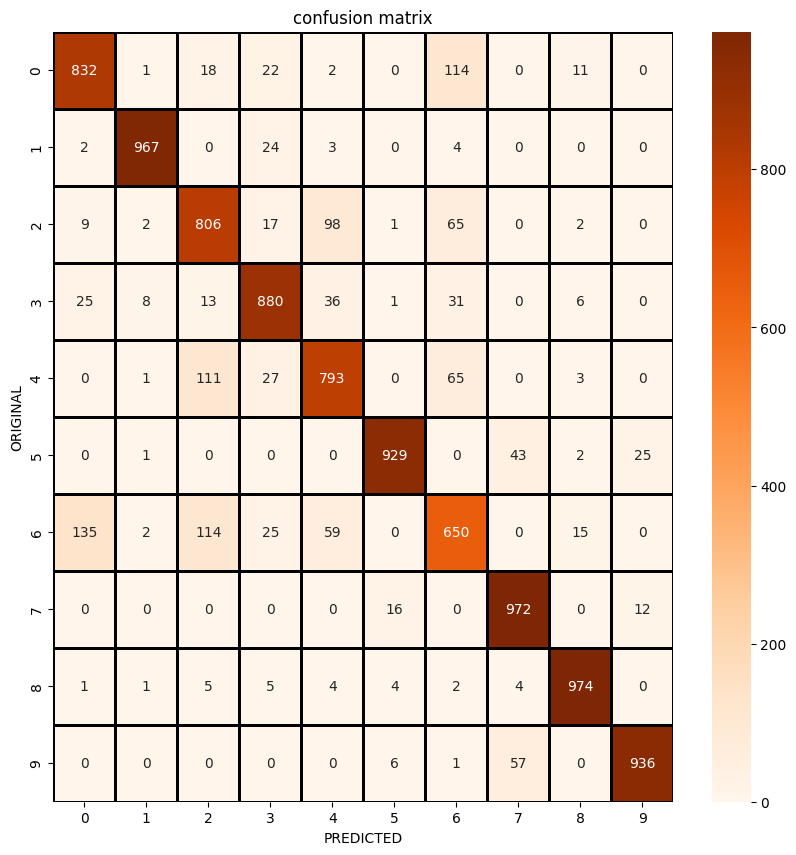

In [51]:
confusion_Matrix(10, 3, 128, 0.001, 'optimizer', 32, 'tanh', 'xavier',0,'crossEntropy')

In [ ]:
confusion_Matrix(10, 3, 128, 0.001, 'optimizer', 32, 'tanh', 'random',0,'crossEntropy')

### mnist


In [ ]:
nadam(0.001, 3, 128, 10, 'tanh', 32, 'xavier',0,'crossEntropy')

In [13]:
!python train.py

2024-03-22 12:46:08.902045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 12:46:08.902120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 12:46:08.903527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 12:46:10.672753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B 

### minst data set

In [41]:
def main_function(epochs, layers, neurons, learningRate, optimizer, batchSize, activationFun, weightInit,weightDecay,loss_Fun):
    if optimizer == "SGD":
        accuracy=stochastic_gradient_descent(epochs, learningRate, layers, neurons, activationFun, weightInit,weightDecay,loss_Fun)
    elif optimizer == "ADAM":
        accuracy=adam(epochs, learningRate, activationFun, layers, neurons, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "NADAM":
        accuracy=nadam(learningRate, layers, neurons, epochs, activationFun, batchSize, weightInit,weightDecay,loss_Fun)

def main_fun():
    wandb.init(project='cs23m035_DL_Assignment1')
    params = wandb.config
    with wandb.init(project='cs23m035_DL_Assignment1', name='optimizer_func_'+params.optimizer+'_weight_initial_'+params.weightInit+'_activation_func_'+params.activationFun) as run:
        main_function(params.maxIterations,
                      params.layers,
                      params.neurons,
                      params.learningRate,
                      params.optimizer,
                      params.batchSize,
                      params.activationFun,
                      params.weightInit,
                      params.weightDecay,
                      params.loss_Fun)

sweep_params = {
    'method': 'bayes',
    'name': 'Accuracy',
    'metric': {
        'goal': 'maximize',
        'name': 'Validation_acc',
    },
    'parameters': {
        'maxIterations': {'values': [10]},
        'layers': {'values': [3]},
        'neurons': {'values': [128]},
        'learningRate': {'values': [0.001]},
        'optimizer': {'values': ['NADAM']},
        'batchSize': {'values': [32]},
        'activationFun': {'values': ['tanh']},
        'weightInit': {'values': ['xavier']},
        'weightDecay': {'values': [0]},
        'loss_Fun':{'values':['crossEntropy']}

    }
}

sweepId = wandb.sweep(sweep_params, project='cs23m035_DL_Assignment1')
wandb.agent(sweepId, function=main_fun,count=1)

Create sweep with ID: cl7fzzsd
Sweep URL: https://wandb.ai/cs23m035/cs23m035_DL_Assignment1/sweeps/cl7fzzsd


wandb: Agent Starting Run: e8g2pv9y with config:
wandb: 	activationFun: tanh
wandb: 	batchSize: 32
wandb: 	layers: 3
wandb: 	learningRate: 0.001
wandb: 	loss_Fun: crossEntropy
wandb: 	maxIterations: 10
wandb: 	neurons: 128
wandb: 	optimizer: NADAM
wandb: 	weightDecay: 0
wandb: 	weightInit: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Accuracy
93.62222222222222 2.814463668140454e-05 93.35 0.0003562448465833812 93.42 7.492273882213108e-05
Accuracy
95.58888888888889 2.6768403322226513e-05 95.08333333333333 0.00013864828048595467 95.12 3.628813390230315e-05
Accuracy
96.56851851851852 3.0103392912353128e-05 96.0 8.561044097287237e-05 95.96000000000001 2.4976351838239152e-05
Accuracy
97.23333333333333 2.334685396643733e-05 96.53333333333333 5.010974488643835e-05 96.44 1.5786152174261386e-05
Accuracy
97.75 1.859615765373461e-05 96.86666666666667 3.234494692508605e-05 96.54 9.746789041430768e-06
Accuracy
98.12037037037037 1.3957115975622347e-05 97.0 2.5715374869235466e-05 96.63000000000001 5.752524166482377e-06
Accuracy
98.40185185185184 1.160767217136457e-05 97.15 2.3083844617495663e-05 96.63000000000001 3.182729937688581e-06
Accuracy
98.61296296296295 1.0394774285269482e-05 97.06666666666666 2.0750491328523534e-05 96.83 1.8286732938773065e-06
Accuracy
98.83333333333333 9.629740468562165e-06 97.2 1.725448032003329e-05 96.

Train_Accuracy,▁▄▅▆▆▇▇▇██
Train_Loss,▇▇█▆▄▂▂▁▁▁
Validation_acc,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
validation_loss,█▄▂▂▁▁▁▁▁▁
Train_Accuracy,99.02778
Train_Loss,1e-05
Validation_acc,97.2
epoch,9
validation_loss,1e-05


In [ ]:
nadam(0.001, 4, 128, 10, 'tanh', 64, 'xavier',0,'crossEntropy')

In [42]:
def main_function(epochs, layers, neurons, learningRate, optimizer, batchSize, activationFun, weightInit,weightDecay,loss_Fun):
    if optimizer == "SGD":
        accuracy=stochastic_gradient_descent(epochs, learningRate, layers, neurons, activationFun, weightInit,weightDecay,loss_Fun)
    elif optimizer == "ADAM":
        accuracy=adam(epochs, learningRate, activationFun, layers, neurons, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "NADAM":
        accuracy=nadam(learningRate, layers, neurons, epochs, activationFun, batchSize, weightInit,weightDecay,loss_Fun)

def main_fun():
    wandb.init(project='cs23m035_DL_Assignment1')
    params = wandb.config
    with wandb.init(project='cs23m035_DL_Assignment1', name='optimizer_func_'+params.optimizer+'_weight_initial_'+params.weightInit+'_activation_func_'+params.activationFun) as run:
        main_function(params.maxIterations,
                      params.layers,
                      params.neurons,
                      params.learningRate,
                      params.optimizer,
                      params.batchSize,
                      params.activationFun,
                      params.weightInit,
                      params.weightDecay,
                      params.loss_Fun)

sweep_params = {
    'method': 'bayes',
    'name': 'Accuracy',
    'metric': {
        'goal': 'maximize',
        'name': 'Validation_acc',
    },
    'parameters': {
        'maxIterations': {'values': [10]},
        'layers': {'values': [4]},
        'neurons': {'values': [128]},
        'learningRate': {'values': [0.001]},
        'optimizer': {'values': ['NADAM']},
        'batchSize': {'values': [64]},
        'activationFun': {'values': ['tanh']},
        'weightInit': {'values': ['xavier']},
        'weightDecay': {'values': [0]},
        'loss_Fun':{'values':['crossEntropy']}

    }
}

sweepId = wandb.sweep(sweep_params, project='cs23m035_DL_Assignment1')
wandb.agent(sweepId, function=main_fun,count=1)

Create sweep with ID: flcawm4e
Sweep URL: https://wandb.ai/cs23m035/cs23m035_DL_Assignment1/sweeps/flcawm4e


wandb: Agent Starting Run: fh34b3qi with config:
wandb: 	activationFun: tanh
wandb: 	batchSize: 64
wandb: 	layers: 4
wandb: 	learningRate: 0.001
wandb: 	loss_Fun: crossEntropy
wandb: 	maxIterations: 10
wandb: 	neurons: 128
wandb: 	optimizer: NADAM
wandb: 	weightDecay: 0
wandb: 	weightInit: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Accuracy
90.18333333333334 0.0001462861769450549 90.16666666666666 0.0014759161506926514 90.22 0.00029463101779357895
Accuracy
93.28518518518518 3.705186046572047e-05 92.73333333333333 0.0003578216411192167 92.89 0.00014245020646806535
Accuracy
94.88703703703703 1.8409327025023305e-05 93.86666666666666 0.00017432259243475588 94.16 7.895097743773305e-05
Accuracy
95.88518518518518 1.107816732588978e-05 94.75 0.00010999310345748783 95.13000000000001 5.273178503268593e-05
Accuracy
96.58333333333333 7.343545623712583e-06 95.41666666666667 7.710185451612423e-05 95.69 3.823962910433792e-05
Accuracy
97.11111111111111 5.491017216113202e-06 95.75 5.75368574292699e-05 95.96000000000001 2.992729832055395e-05
Accuracy
97.45185185185186 3.984682990741454e-06 96.1 4.510265356870679e-05 96.16 2.305793559829401e-05
Accuracy
97.75555555555555 2.847669743792782e-06 96.21666666666667 3.572029022343533e-05 96.38 1.7469937987049812e-05
Accuracy
98.00740740740741 2.2298960746395492e-06 96.39999999999999 2.84

Train_Accuracy,▁▄▅▆▇▇▇███
Train_Loss,█▃▂▁▁▁▁▁▁▁
Validation_acc,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
validation_loss,█▃▂▁▁▁▁▁▁▁
Train_Accuracy,98.22963
Train_Loss,0.0
Validation_acc,96.48333
epoch,9
validation_loss,2e-05


In [ ]:
adam(10, 0.001, 'tanh', 4, 128, 64, 'xavier',0,'crossEntropy')

In [43]:
def main_function(epochs, layers, neurons, learningRate, optimizer, batchSize, activationFun, weightInit,weightDecay,loss_Fun):
    if optimizer == "SGD":
        accuracy=stochastic_gradient_descent(epochs, learningRate, layers, neurons, activationFun, weightInit,weightDecay,loss_Fun)
    elif optimizer == "ADAM":
        accuracy=adam(epochs, learningRate, activationFun, layers, neurons, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "NADAM":
        accuracy=nadam(learningRate, layers, neurons, epochs, activationFun, batchSize, weightInit,weightDecay,loss_Fun)

def main_fun():
    wandb.init(project='cs23m035_DL_Assignment1')
    params = wandb.config
    with wandb.init(project='cs23m035_DL_Assignment1', name='optimizer_func_'+params.optimizer+'_weight_initial_'+params.weightInit+'_activation_func_'+params.activationFun) as run:
        main_function(params.maxIterations,
                      params.layers,
                      params.neurons,
                      params.learningRate,
                      params.optimizer,
                      params.batchSize,
                      params.activationFun,
                      params.weightInit,
                      params.weightDecay,
                      params.loss_Fun)

sweep_params = {
    'method': 'bayes',
    'name': 'Accuracy',
    'metric': {
        'goal': 'maximize',
        'name': 'Validation_acc',
    },
    'parameters': {
        'maxIterations': {'values': [10]},
        'layers': {'values': [4]},
        'neurons': {'values': [128]},
        'learningRate': {'values': [0.001]},
        'optimizer': {'values': ['ADAM']},
        'batchSize': {'values': [64]},
        'activationFun': {'values': ['tanh']},
        'weightInit': {'values': ['xavier']},
        'weightDecay': {'values': [0]},
        'loss_Fun':{'values':['crossEntropy']}

    }
}

sweepId = wandb.sweep(sweep_params, project='cs23m035_DL_Assignment1')
wandb.agent(sweepId, function=main_fun,count=1)

Create sweep with ID: 9lzihth2
Sweep URL: https://wandb.ai/cs23m035/cs23m035_DL_Assignment1/sweeps/9lzihth2


wandb: Agent Starting Run: nza11vso with config:
wandb: 	activationFun: tanh
wandb: 	batchSize: 64
wandb: 	layers: 4
wandb: 	learningRate: 0.001
wandb: 	loss_Fun: crossEntropy
wandb: 	maxIterations: 10
wandb: 	neurons: 128
wandb: 	optimizer: ADAM
wandb: 	weightDecay: 0
wandb: 	weightInit: xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Accuracy
91.34074074074074 0.00011578402413603201 91.01666666666667 0.0011213735142861284 91.3 0.0003903585189941847
Accuracy
94.00185185185185 6.228984467431487e-05 93.36666666666666 0.0004563047001598221 93.56 0.00012997891871126865
Accuracy
95.5037037037037 3.571169412450032e-05 94.63333333333334 0.00023672940435429704 94.66 5.912170605235003e-05
Accuracy
96.52222222222223 2.2334338946950236e-05 95.51666666666667 0.0001408267411382193 95.46 3.932616003143749e-05
Accuracy
97.21666666666667 1.3021021595080426e-05 96.01666666666667 9.559166919932178e-05 95.98 2.746862480340587e-05
Accuracy
97.62962962962963 9.886866586564504e-06 96.33333333333334 6.913551438389578e-05 96.27 1.8478954014391752e-05
Accuracy
97.9148148148148 8.047174260630447e-06 96.68333333333334 5.077248586327707e-05 96.39 1.2500315215720512e-05
Accuracy
98.12962962962963 6.048855693838921e-06 96.61666666666666 3.808969364991782e-05 96.44 9.0201581910717e-06
Accuracy
98.28148148148148 4.957052075345766e-06 96.5666666666

Train_Accuracy,▁▄▅▆▇▇████
Train_Loss,█▅▃▂▂▁▁▁▁▁
Validation_acc,▁▄▅▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
validation_loss,█▄▂▂▁▁▁▁▁▁
Train_Accuracy,98.37037
Train_Loss,0.0
Validation_acc,96.48333
epoch,9
validation_loss,3e-05


### conncet to wandb

In [ ]:
def main_function(epochs, layers, neurons, learningRate, optimizer, batchSize, activationFun, weightInit,weightDecay,loss_Fun):
    if optimizer == "SGD":
        accuracy=stochastic_gradient_descent(epochs, learningRate, layers, neurons, activationFun, weightInit,weightDecay,loss_Fun)
    elif optimizer == "MGD":
        accuracy=momentum_gradient_descent(epochs, learningRate, layers, neurons, activationFun, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "NAGD":
        accuracy=nesterov_accelerated_gradient_descent(epochs, layers, neurons, learningRate, activationFun, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "RMSPROP":
        accuracy=rms_prop(epochs, layers, neurons, learningRate, activationFun, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "ADAM":
        accuracy=adam(epochs, learningRate, activationFun, layers, neurons, batchSize, weightInit,weightDecay,loss_Fun)
    elif optimizer == "NADAM":
        accuracy=nadam(learningRate, layers, neurons, epochs, activationFun, batchSize, weightInit,weightDecay,loss_Fun)

def main_fun():
    wandb.init(project='cs23m035_DL_Assignment1')
    params = wandb.config
    with wandb.init(project='cs23m035_DL_Assignment1', name='optimizer_func_'+params.optimizer+'_weight_initial_'+params.weightInit+'_activation_func_'+params.activationFun) as run:
        main_function(params.maxIterations,
                      params.layers,
                      params.neurons,
                      params.learningRate,
                      params.optimizer,
                      params.batchSize,
                      params.activationFun,
                      params.weightInit,
                      params.weightDecay,
                      params.loss_Fun)

sweep_params = {
    'method': 'bayes',
    'name': 'Accuracy',
    'metric': {
        'goal': 'maximize',
        'name': 'Validation_acc',
    },
    'parameters': {
        'maxIterations': {'values': [5,10]},
        'layers': {'values': [3,4,5]},
        'neurons': {'values': [32, 64,128]},
        'learningRate': {'values': [1e-3,1e-4]},
        'optimizer': {'values': ['SGD', 'MGD', 'NAGD', 'RMSPROP', 'ADAM', 'NADAM']},
        'batchSize': {'values': [16, 32, 64]},
        'activationFun': {'values': ['tanh','sigmoid','relu']},
        'weightInit': {'values': ['random', 'xavier']},
        'weightDecay': {'values': [0,0.0005,0.5]},
        'loss_Fun':{'values':['crossEntropy','MSE']}

    }
}

sweepId = wandb.sweep(sweep_params, project='cs23m035_DL_Assignment1')
wandb.agent(sweepId, function=main_fun)
